In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

from pydantic import BaseModel, Field, ConfigDict, field_validator
from typing import Annotated, List, Optional, Dict, Any, Literal
import json

In [2]:
llm = llm = ChatOpenAI(model="deepseek-chat", openai_api_key=os.getenv("DEEPSEEK_API_KEY"), openai_api_base='https://api.deepseek.com')


## 状态

In [3]:
class State(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)

    messages: Annotated[List[AnyMessage], add_messages] = Field(default_factory=list, title="对话列表")
    prompt: str = Field(default="", title="PromptGenerator生成的Prompt")
    success: bool = Field(default=False, title="节点执行是否成功")
    log: str = Field(default="", title="节点执行日志")

    @field_validator("messages", mode="before")
    def validate_messages(cls, v, info):
        if 'messages' in info.data:
            return add_messages(info.data['messages'], v)
        else:
            return v if isinstance(v, list) else [v]
    

## PromptGenerator

In [4]:
class PromptFormat(BaseModel):
    knowledge_mastery: str = Field(
        ...,
        description="学生当前知识掌握程度评估",
        example="已准确掌握图遍历和递归等基础概念"
    )
    guiding_direction: List[str] = Field(
        ...,
        description="引导方向",
        example=[
            "设计迷宫问题比较两种算法效率",
            "引入加权图下的扩展应用",
            "探讨递归实现DFS的栈溢出风险"
        ]
    )

    @property
    def as_str(self):
        guiding_direction_str = "\n".join([f"{i+1}. {direction}" for i, direction in enumerate(self.guiding_direction)])
        return f"学生当前知识掌握程度评估：{self.knowledge_mastery}\n建议引导方向：{guiding_direction_str}"

with open('/root/autodl-tmp/EasyDS/src/agents/prompts/prompt_generator_prompt.txt', 'r', encoding='utf-8') as f:
    prompt_generator_prompts = f.read()

def prompt_generator(state: State) -> State:
    """根据当前状态生成新的Prompt"""
    try:
        conversation = ""
        for message in state.messages:
            if isinstance(message, HumanMessage):
                conversation += f"user: {message.content}\n"
            elif isinstance(message, AIMessage):
                conversation += f"assistant: {message.content}\n"
        prompt = ChatPromptTemplate([
            ("system", prompt_generator_prompts),
            ("human", "{conversation}"),
        ])
        prompt_generator_chain = prompt | llm.with_structured_output(PromptFormat)
        prompt = prompt_generator_chain.invoke({"conversation": conversation})
        return State(prompt=prompt.as_str, success=True, log=f"Prompt生成成功")
    except Exception as e:
        return State(prompt="", success=False, log=str(e))

## TeacherAgent Node

In [5]:
with open('/root/autodl-tmp/EasyDS/src/agents/prompts/teacher_agent_prompt.txt', 'r', encoding='utf-8') as f:
    teacher_agent_prompt = f.read()

def teacher_agent(state: State) -> State:
    """根据当前状态生成新的Prompt"""
    try:
        conversation = ""
        for message in state.messages:
            if isinstance(message, HumanMessage):
                conversation += f"user: {message.content}\n"
            elif isinstance(message, AIMessage):
                conversation += f"assistant: {message.content}\n"
        
        teacher_agent_prompt = PromptTemplate.from_template(teacher_agent_prompt)
        teacher_agent_prompt = teacher_agent_prompt.invoke({"prompt_generator_prompt": state.prompt})

        prompt = ChatPromptTemplate([
            ("system", teacher_agent_prompt),
            ("human", "{conversation}"),
        ])
        teacher_agent_chain = prompt | llm
        guidance = teacher_agent_chain.invoke({"conversation": conversation})
        return State(route="teacher_agent", success=True, log=f"TeacherAgent生成成功", messages=[AIMessage(content=guidance)])
    except Exception as e:
        return State(route="teacher_agent", success=False, log=str(e))


## RouterNode

In [6]:
# class RouterState(State):
#     next_node: str = Field(default="teacher_agent", title="下一个节点")

class RouterStructure(BaseModel):
    next_node: Literal["teacher_agent", "prompt_generator"]

with open('/root/autodl-tmp/EasyDS/src/agents/prompts/router_node_prompt.txt', 'r', encoding='utf-8') as f:
    router_node_prompt = f.read()

def router_node(state: State) -> State:
    """根据当前状态选择下一个节点"""
    try:
        conversation = ""
        for message in state.messages:
            if isinstance(message, HumanMessage):
                conversation += f"user: {message.content}\n"
            elif isinstance(message, AIMessage):
                conversation += f"assistant: {message.content}\n"

        prompt = ChatPromptTemplate([
            ("system", router_node_prompt),
            ("human", "{conversation}"),
        ])
        router_node_chain = prompt | llm.with_structured_output(RouterStructure)
        router_node_result = router_node_chain.invoke({"conversation": conversation})
        return State(next_node=router_node_result.next_node, success=True, log=f"RouterNode生成成功")
    except Exception as e:
        return State(next_node="end", success=False, log=str(e))

## Router

In [7]:
def router(state: State) -> State:
    """根据当前状态选择下一个节点"""
    if state.next_node == "teacher_agent":
        return "teacher_agent"
    elif state.next_node == "prompt_generator":
        return "prompt_generator"
    else:
        return "__end__"


## MainGraph

In [14]:
workflow = StateGraph(State)

workflow.add_node("router", router)
workflow.add_node("prompt_generator", prompt_generator)
workflow.add_node("teacher_agent", teacher_agent)

workflow.add_conditional_edges(
    "router",
    router,
    {
        "prompt_generator": "prompt_generator",
        "teacher_agent": "teacher_agent",
        "__end__": END
    }
)

workflow.add_edge(START, "router")
workflow.add_edge("prompt_generator", "teacher_agent")
workflow.add_edge("teacher_agent", END)

memory = MemorySaver()

graph = workflow.compile(checkpointer=memory)


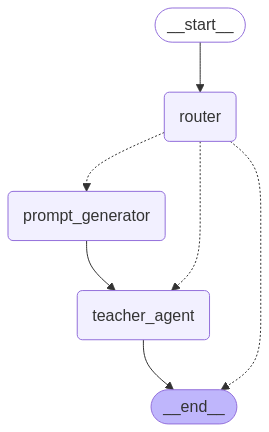

In [15]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=2).draw_mermaid_png()))